In [55]:
import os
os.chdir(r"c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox")
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from unidecode import unidecode

In [7]:
with open("data/cleaned_data/cross_val_split.pkl", "rb") as read_file:
    folds = pickle.load(read_file)

In [8]:
def objective(trial):
    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    scores = []
    for fold in folds[:-1]:
        clf.fit(fold["Train X Tfidf"], fold["Train y classes"])
        scores.append(clf.score(fold["Test X Tfidf"], fold["Test y classes"]))

    return np.mean(scores)

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2023-01-24 09:59:26,938] A new study created in memory with name: no-name-6addbcc6-826e-4ceb-946b-dec0588a961e
[I 2023-01-24 09:59:27,485] Trial 0 finished with value: 0.6310820624546114 and parameters: {'C': 0.20523591812961905, 'c_weight': None}. Best is trial 0 with value: 0.6310820624546114.
[I 2023-01-24 09:59:28,076] Trial 1 finished with value: 0.593681917211329 and parameters: {'C': 0.00032003679905692344, 'c_weight': None}. Best is trial 0 with value: 0.6310820624546114.
[I 2023-01-24 09:59:28,391] Trial 2 finished with value: 0.8133623819898329 and parameters: {'C': 0.011587636595417509, 'c_weight': 'balanced'}. Best is trial 2 with value: 0.8133623819898329.
[I 2023-01-24 09:59:29,278] Trial 3 finished with value: 0.7752360203340596 and parameters: {'C': 0.540383604541825, 'c_weight': None}. Best is trial 2 with value: 0.8133623819898329.
[I 2023-01-24 09:59:30,509] Trial 4 finished with value: 0.8257080610021785 and parameters: {'C': 2.101960304235772, 'c_weight': None}.

In [11]:
study.best_params

{'C': 2.6716377026717955, 'c_weight': 'balanced'}

In [37]:
clf = LogisticRegression(C=2.672, class_weight="balanced")
scores = []
for fold in folds[:-1]:
    clf.fit(fold["Train X Tfidf"], fold["Train y classes"])
    scores.append(clf.score(fold["Test X Tfidf"], fold["Test y classes"]))

np.mean(scores)

0.8449527959331882

In [38]:
test_set = folds[-1]
#clf = LogisticRegression(C=2.672, class_weight="balanced")
clf.fit(test_set["Train X Tfidf"], test_set["Train y classes"])
clf.score(test_set["Test X Tfidf"], test_set["Test y classes"])

0.8823529411764706

In [39]:
pred = clf.predict(test_set["Test X Tfidf"])

acc = accuracy_score(pred, test_set["Test y classes"])
recall = recall_score(pred, test_set["Test y classes"], average="weighted")
precision = precision_score(pred, test_set["Test y classes"], average="weighted")
f1 = f1_score(pred, test_set["Test y classes"], average="weighted")

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
print("Classification with logistic regression and Tf-Idf model:")
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Classification with logistic regression and Tf-Idf model:
Score: 0.882
F1: 0.91
Recall: 0.882
Precision: 0.941


In [41]:
cm = confusion_matrix(y_true=test_set["Test y classes"], y_pred=pred, labels=clf.classes_)

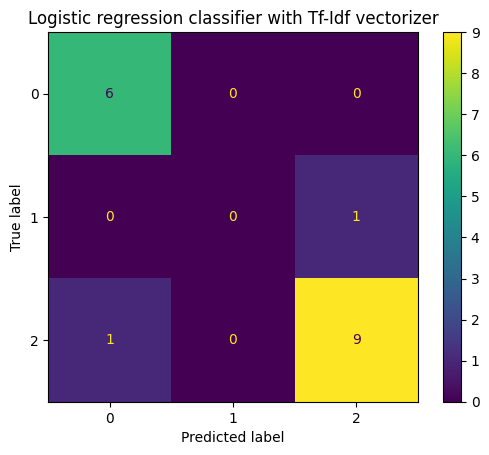

In [44]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.title("Logistic regression classifier with Tf-Idf vectorizer")
plt.show()